In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'lab_name="churchlandlab"' & 'subject_project = "churchland_learninglifespan"'

########### WEIGHINGS ########### 
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date > "2020-02-22"'
#baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2020-02-25"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
#avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
#bb = subj * avg_baseline_weight_date
weight_df = pd.DataFrame(b.fetch(as_dict=True))
#baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
weight_df.tail(n=5)

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,subject_strain,lab_name,subjectlab_ts,subjectproject_ts,avg_weight
342,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-05,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-05 13:41:59,2020-05-05 13:41:44,29.450001
343,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-13,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-05 13:41:59,2020-05-05 13:41:44,29.879999
344,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-02-25,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-05 13:41:59,2020-05-05 13:41:44,33.009998
345,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-06,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-05 13:41:59,2020-05-05 13:41:44,29.070000
346,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-14,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-05 13:41:59,2020-05-05 13:41:44,30.059999


In [3]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

normalized_df = weight_df.copy()
# day 0 is the start of the experiment
normalized_df['session_day'] = (normalized_df['session_date'] - (datetime(2020, 3, 2)).date()).dt.days

normalized2 = pd.DataFrame([])
for index, sjdat in normalized_df.groupby(['subject_uuid']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat.loc[sjdat.session_day < 1, 'avg_weight'].mean()
    normalized2 = normalized2.append(sjdat)

########### CONDITIONS ########### 
CA = 'Citric Acid'
condition_map = {'CSHL061':CA, 'CSHL062':CA, 'CSHL063':CA, 'CSHL064':CA, 
'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
'CSHL070':CA, 'CSHL071':CA, 'CSHL072':CA, 'CSHL073':CA, 
'CSHL074':CA, 'CSHL075':CA}

# remove mice that have dropped out
condition_map = {'CSHL063':CA, 
'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
'CSHL070':CA, 'CSHL071':CA, 'CSHL072':CA, 'CSHL073':CA, 
'CSHL074':CA, 'CSHL075':CA}

normalized2['condition'] = normalized2.subject_nickname.map(condition_map)

# choose only these animals
normalized2 = normalized2.loc[normalized2.subject_nickname.isin(condition_map.keys()), :]
sorted(normalized2.subject_nickname.unique())
sorted(normalized2.session_date.unique())


/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


[datetime.date(2020, 2, 24),
 datetime.date(2020, 2, 25),
 datetime.date(2020, 2, 26),
 datetime.date(2020, 2, 27),
 datetime.date(2020, 2, 28),
 datetime.date(2020, 3, 2),
 datetime.date(2020, 3, 3),
 datetime.date(2020, 3, 4),
 datetime.date(2020, 3, 5),
 datetime.date(2020, 3, 6),
 datetime.date(2020, 3, 7),
 datetime.date(2020, 3, 8),
 datetime.date(2020, 3, 9),
 datetime.date(2020, 3, 10),
 datetime.date(2020, 3, 11),
 datetime.date(2020, 3, 12),
 datetime.date(2020, 3, 13),
 datetime.date(2020, 3, 14),
 datetime.date(2020, 3, 15),
 datetime.date(2020, 3, 16),
 datetime.date(2020, 3, 17),
 datetime.date(2020, 3, 18)]

In [4]:
# compute age range
normalized_df['session_age'] = (normalized_df.session_date - normalized_df.subject_birth_date)
normalized_df.session_age.describe()

count                         347
mean     316 days 13:16:46.340057
std       85 days 07:42:39.118338
min             195 days 00:00:00
25%             217 days 00:00:00
50%             330 days 00:00:00
75%             341 days 00:00:00
max             523 days 00:00:00
Name: session_age, dtype: object

UsageError: Line magic function `%ax.text(-5,` not found.


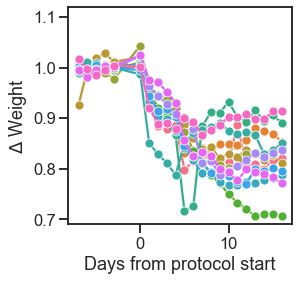

In [5]:
palette = sns.xkcd_palette(['raspberry'])
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
    
sns.lineplot(x="session_day", y="avg_weight", hue='subject_nickname',
             estimator=None, err_style='bars', marker='o', units='subject_nickname',
             ci=68, data=normalized2, ax=ax, legend=False)
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("$\Delta$ Weight")     
ax.set(ylim=[0.69, 1.12], yticks=[0.7, 0.8, 0.9, 1, 1.1])
%ax.text(-5, 0.75, 'n = 15', {'color':'k', 'fontsize':16})

f.tight_layout()
sns.despine(trim=True)
#f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))


In [ ]:
# palette = sns.xkcd_palette(['raspberry'])
# f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
    
# sns.lineplot(x="session_day", y="avg_weight", color='crimson', err_style='bars', marker='o',
#              ci=68, data=normalized2, ax=ax, legend=False)
# ax.set_xlabel("Days from protocol start")    
# ax.set_ylabel("$\Delta$ Weight")     
# ax.set(ylim=[0.69, 1.12], yticks=[0.7, 0.8, 0.9, 1, 1.1])
# #ax.text(-5, 0.75, 'n = %d'%normalized2.subject_nickname.nunique(), {'color':'k', 'fontsize':16})

# f.tight_layout()
# sns.despine(trim=True)

# f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))


,protocol_number,avg_weight,session_day
count,240.0,240.000000,240.000000
mean,1.0,0.892794,5.116667
std,0.0,0.079819,6.976570
min,1.0,0.716134,-7.000000
25%,1.0,0.825191,0.000000
50%,1.0,0.885664,6.000000
75%,1.0,0.982907,11.000000
max,1.0,1.043427,16.000000


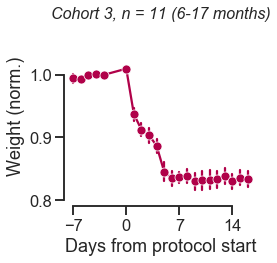

In [7]:
# REMOVE ONE OVERWEIGHT MOUSE
normalized3 = normalized2[~normalized2['subject_nickname'].isin(['CSHL071'])]
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
    
palette = sns.xkcd_palette(['raspberry'])

sns.lineplot(x="session_day", y="avg_weight", err_style='bars', marker='o',
             ci=68, data=normalized3, ax=ax, legend=False, color=palette[0])
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("Weight (norm.)")     
ax.set(ylim=[0.79, 1.08], yticks=[0.8, 0.9, 1], xticks=[-7, 0, 7, 14])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
ax.set_title('Cohort 3, n = %d (6-17 months)'%normalized3.subject_nickname.nunique(), 
            fontsize=16, fontstyle='italic')
f.tight_layout()
sns.despine(trim=True)
#f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
f.savefig(os.path.join(figpath, "suppfig2.png"), dpi=600)

normalized3.describe()

In [ ]:

# g = sns.FacetGrid(normalized_df, col='subject_nickname', col_wrap=4)
# g.map(sns.lineplot, "session_day", "avg_weight", marker='o')
# g.set_titles('{col_name}')

In [ ]:

# g = sns.FacetGrid(normalized2, col='subject_nickname', col_wrap=4)
# g.map(sns.lineplot, "session_day", "avg_weight", marker='o')
# g.set_titles('{col_name}')

In [ ]:
normalized3.describe()